# CIFAR 10 Using Support Vector Machine

In [2]:
import cPickle as pickle
import numpy as np
import os
from scipy.misc import imread

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

### Run some setup code for this notebook

In [3]:
import random
import numpy as np
#from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### CIFAR-10 Data Loading and Preprocessing

In [5]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/CIFAR10'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape


Training data shape:  (50000L, 32L, 32L, 3L)
Training labels shape:  (50000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)


### Split the data into training, validation and testing sets

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape


Train data shape:  (49000L, 32L, 32L, 3L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 32L, 32L, 3L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 32L, 32L, 3L)
Test labels shape:  (1000L,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000L, 3072L)
Validation data shape:  (1000L, 3072L)
Test data shape:  (1000L, 3072L)
dev data shape:  (500L, 3072L)


In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
# print mean_image[:10] # print a few of the elements

In [9]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [10]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape



(49000L, 3073L) (1000L, 3073L) (1000L, 3073L) (500L, 3073L)


### SVM Classifier methods

In [12]:
# ## SVM Classifier
import numpy as np
from random import shuffle
from numpy import corrcoef
import time

def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops).
  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.
  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength
  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  dW = np.zeros(W.shape) # initialize the gradient as zero

  # compute the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  Loss = np.zeros([num_train, num_classes])
  for i in xrange(num_train):
    scores = X[i].dot(W)
    correct_class_score = scores[y[i]]
    for j in xrange(num_classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1 # note delta = 1
      if margin > 0:
        loss += margin
        dW[:,j] += X[i]
        dW[:,y[i]] -= X[i] 
    pass
  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
  loss /= num_train
  dW   /= num_train
  # Add regularization to the loss.
  loss += 0.5 * reg * np.sum(W * W)
  
  #Adding the gradient of the regularization
  dW += reg*W
  #############################################################################
  # TODO:                                                                     #
  # Compute the gradient of the loss function and store it dW.                #
  # Rather that first computing the loss and then computing the derivative,   #
  # it may be simpler to compute the derivative at the same time that the     #
  # loss is being computed. As a result you may need to modify some of the    #
  # code above to compute the gradient.                                       #
  #############################################################################
  return loss, dW

#from cs231n.classifiers.linear_svm import svm_loss_naive


In [13]:
def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation.
  Inputs and outputs are the same as svm_loss_naive.
  """
  loss = 0.0
  dW = np.zeros(W.shape) # initialize the gradient as zero
  num_classes = W.shape[1]
  num_train = X.shape[0]
  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the structured SVM loss, storing the    #
  # result in loss.                                                           #
  #############################################################################
  #Calculating the score
  scores = X.dot(W)
  Y = np.zeros(scores.shape)
  for i,row in enumerate(Y):
    row[y[i]] = 1
  
  Correct_class_scores = np.array( [ [ scores[i][y[i]] ]*num_classes for i in range(num_train) ] )  
  Margin = scores - Correct_class_scores + ((scores - Correct_class_scores) != 0)
  X_with_margin_count = np.multiply(X.T , ( Margin > 0).sum(1) ).T

  loss += np.sum((Margin>0)*Margin)/num_train
  loss += 0.5 * reg * np.sum(W * W)
  dW += ( Margin > 0 ).T.dot(X).T/num_train
  dW -= (Margin == 0).T.dot(X_with_margin_count).T/num_train
  dW += reg*W
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################


  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the gradient for the structured SVM     #
  # loss, storing the result in dW.                                           #
  #                                                                           #
  # Hint: Instead of computing the gradient from scratch, it may be easier    #
  # to reuse some of the intermediate values that you used to compute the     #
  # loss.                                                                     #
  #############################################################################
  pass
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return loss, dW

In [19]:
import numpy as np
import math
from random import shuffle

def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops)
  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.
  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength
  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
#   
#   print "W shape", W.shape
#   print "X shape", X.shape
  #############################################################################
  # TODO: Compute the softmax loss and its gradient using explicit loops.     #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  for i in xrange(num_train):
      
      scores = X[i].dot(W)
      exp_scores = pow(math.e, scores)
      exp_scores_sum = sum(exp_scores)
      #Loss update
      loss -= np.log( exp_scores[y[i]]/exp_scores_sum )
      #Gradient update
      dW[:,y[i]] -= X[i]
      for j in xrange(num_classes):
        dW[:,j] += X[i]*exp_scores[j]/exp_scores_sum
  
  loss /= num_train
  dW /= num_train    
  loss += 0.5 * reg * np.sum(W * W)
  dW += reg*W

  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW


def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.
  Inputs and outputs are the same as softmax_loss_naive.
  """
#   print y.shape
#   print X.shape
#   Label_data = np.dstack((y,X))
#   print Label_data
#   Label_data.sort()
#   y = Label_data[:,0]
#   x = Label_data[:,1:]

  #Sorting the input based on the class
  num_classes = W.shape[1]
  num_train = X.shape[0]
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  X1 = X.dot(W)
  scores = pow(math.e,X1)
  #normarlizing the score
  scores = (scores.T/np.sum(scores, axis = 1)).T
  
  Y = np.zeros([num_train, num_classes])
  for i,row in enumerate(Y):
    row[y[i]] = 1
  
  loss_ma = np.ma.log(scores*Y)
  loss = np.sum( - loss_ma.filled(0))/num_train + 0.5 * reg * np.sum(W * W)  
  
  dX1 = scores - Y
  dW = ((dX1.T).dot(X)).T/num_train + reg*W
  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  pass
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW

### Linear classifier class used in the code

In [20]:
import numpy as np
import math
#from cs231n.classifiers.linear_svm import *
#from cs231n.classifiers.softmax import *

class LinearClassifier(object):

  def __init__(self,):
      self.W = None
      self.learning_rate = None
      self.reg = None
      self.batch_size = None
  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=True):
    """
    Train this linear classifier using stochastic gradient descent.
    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.
    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    
    if self.W is None:
      # lazily initialize W
        self.W = 0.001 * np.random.randn(dim, num_classes)
    
    # Run stochastic gradient descent to optimize W
    loss_history = []
    loss_prev = float('inf')
    for it in xrange(num_iters):

      #########################################################################
      # TODO:                                                                 #
      # Sample batch_size elements from the training data and their           #
      # corresponding labels to use in this round of gradient descent.        #
      # Store the data in X_batch and their corresponding labels in           #
      # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
      # and y_batch should have shape (batch_size,)                           #
      #                                                                       #
      # Hint: Use np.random.choice to generate indices. Sampling with         #
      # replacement is faster than sampling without replacement.              #
      #########################################################################
      
      batch_indicies = np.random.choice(num_train, batch_size, replace = True)
      X_batch = X[batch_indicies]
      y_batch = y[batch_indicies]
      
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)
      loss_prev = loss
      # perform parameter update
      #########################################################################
      # TODO:                                                                 #
      # Update the weights using the gradient and the learning rate.          #
      #########################################################################
      self.W -= learning_rate*grad
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      if verbose and (it) % 100 == 0:
        print 'iteration %d / %d: loss %f' % (it, num_iters, loss)

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.
    Inputs:
    - X: D x N array of training data. Each column is a D-dimensional point.
    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################
    Scores = X.dot(self.W)
    y_pred = np.argmax(Scores, axis = 1)
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.
    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.
    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass


class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch, reg):
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)


### Actual Training and Testing Part

In [21]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [( 5e-7,1500), (1e-6,600), (5e-6,400)]
regularization_strengths = [5e3, 1e4, 5e4, 1e5, 5e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1  # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        print("LR",learning_rate,"reg",reg)
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=learning_rate[0], reg=reg,
                      num_iters=learning_rate[1], verbose=True)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        results[(learning_rate[0],reg)] = (np.mean(y_train == y_train_pred),np.mean(y_val == y_val_pred))
        
        if best_val < np.mean(y_val == y_val_pred):
            best_val = np.mean(y_val == y_val_pred)
            best_parameters = { 'LR':learning_rate[0], 'reg': reg}

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

('LR', (5e-07, 1500), 'reg', 5000.0)
iteration 0 / 1500: loss 98.974114
iteration 100 / 1500: loss 52.706646
iteration 200 / 1500: loss 32.857010
iteration 300 / 1500: loss 22.191214
iteration 400 / 1500: loss 14.307888
iteration 500 / 1500: loss 10.671344
iteration 600 / 1500: loss 8.710171
iteration 700 / 1500: loss 6.998899
iteration 800 / 1500: loss 6.900780
iteration 900 / 1500: loss 5.734880
iteration 1000 / 1500: loss 4.907061
iteration 1100 / 1500: loss 4.960602
iteration 1200 / 1500: loss 5.609805
iteration 1300 / 1500: loss 5.036106
iteration 1400 / 1500: loss 4.054852
('LR', (5e-07, 1500), 'reg', 10000.0)
iteration 0 / 1500: loss 173.380093
iteration 100 / 1500: loss 61.032328
iteration 200 / 1500: loss 25.576415
iteration 300 / 1500: loss 13.082165
iteration 400 / 1500: loss 8.002220
iteration 500 / 1500: loss 6.681306
iteration 600 / 1500: loss 5.754342
iteration 700 / 1500: loss 5.245250
iteration 800 / 1500: loss 4.686301
iteration 900 / 1500: loss 4.968957
iteration 100

### Cross Validation Results

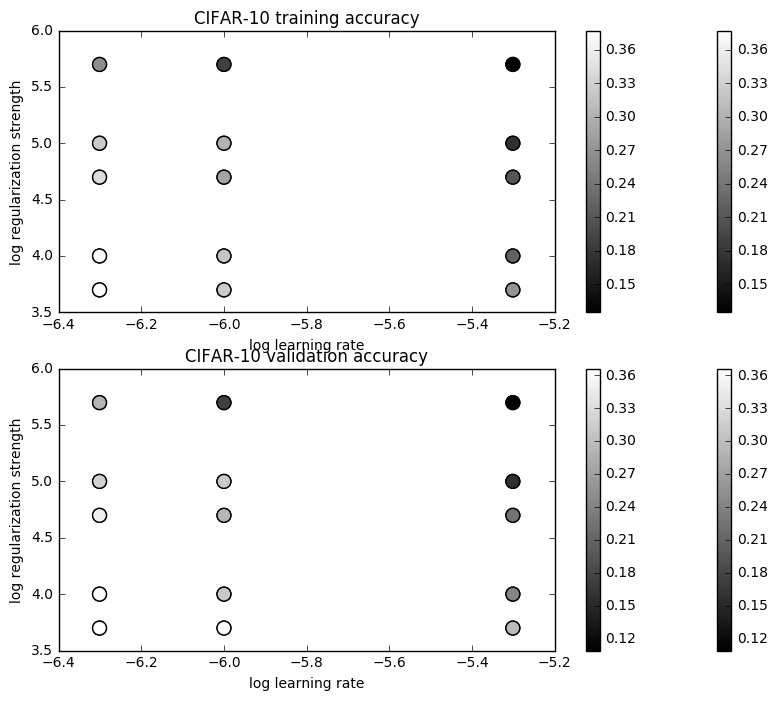

In [23]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()


### Test Accuracy Results

In [24]:
best_svm = LinearSVM()
best_svm.train(X_train, y_train, learning_rate=best_parameters['LR'], reg=best_parameters['reg'],
                      num_iters=2000, verbose=True)
        
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

iteration 0 / 2000: loss 172.337941
iteration 100 / 2000: loss 61.961981
iteration 200 / 2000: loss 24.371712
iteration 300 / 2000: loss 11.939157
iteration 400 / 2000: loss 7.624789
iteration 500 / 2000: loss 5.484497
iteration 600 / 2000: loss 5.187293
iteration 700 / 2000: loss 5.282599
iteration 800 / 2000: loss 5.281886
iteration 900 / 2000: loss 5.772357
iteration 1000 / 2000: loss 4.914389
iteration 1100 / 2000: loss 4.983076
iteration 1200 / 2000: loss 5.021063
iteration 1300 / 2000: loss 4.991259
iteration 1400 / 2000: loss 5.316892
iteration 1500 / 2000: loss 6.000399
iteration 1600 / 2000: loss 5.076672
iteration 1700 / 2000: loss 4.747854
iteration 1800 / 2000: loss 4.428205
iteration 1900 / 2000: loss 5.027543
linear SVM on raw pixels final test set accuracy: 0.350000


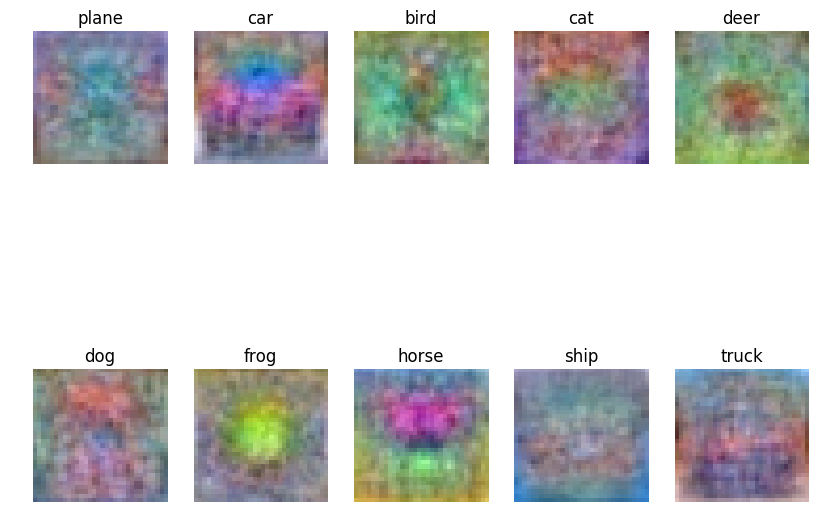

In [25]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])
plt.show()
